<a href="https://colab.research.google.com/github/wvsvenkat/MyoPS2020/blob/main/uNetTwoStage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Stage 1 model loaded (4-class).
[Stage2] Epoch 1/50 - Train Loss: 1.0954
[Stage2] Epoch 2/50 - Train Loss: 1.0302
[Stage2] Epoch 3/50 - Train Loss: 0.9882
[Stage2] Epoch 4/50 - Train Loss: 0.9578
[Stage2] Epoch 5/50 - Train Loss: 0.9316
[Stage2] Epoch 5 - Val Loss: 0.9236, Mean Dice: 0.010, Myocardium: 0.017
Saved Stage 2 checkpoint: /content/drive/MyDrive/MyoPS2020/checkpoints/unet_stage2_epoch5.pth
[Stage2] Epoch 6/50 - Train Loss: 0.9056
[Stage2] Epoch 7/50 - Train Loss: 0.8794
[Stage2] Epoch 8/50 - Train Loss: 0.8540
[Stage2] Epoch 9/50 - Train Loss: 0.8301
[Stage2] Epoch 10/50 - Train Loss: 0.8085
[Stage2] Epoch 10 - Val Loss: 0.8061, Mean Dice: 0.010, Myocardium: 0.017
Saved Stage 2 checkpoint: /content/drive/MyDrive/MyoPS2020/checkpoints/unet_stage2_epoch10.pth
[Stage2] Epoch 11/50 - Train Loss: 0.7889
[Stage2] Epoch 12/50 - Train Loss: 0.7710
[Stage2]

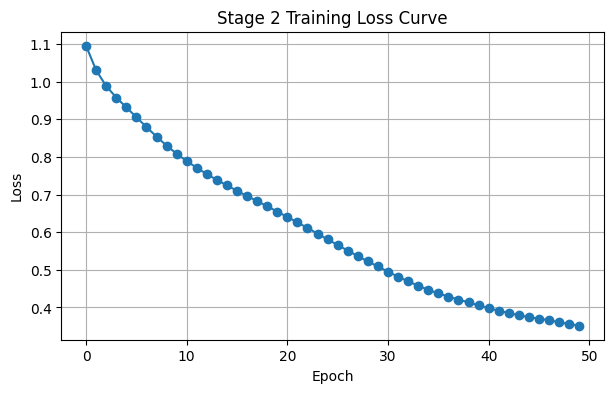

Saved Stage 2 validation summary to /content/drive/MyDrive/MyoPS2020/predictions_stage2/val_summary_stage2.csv


In [2]:
# ============================================
# 📦 Setup & Imports
# ============================================
!pip install monai nibabel pydicom pandas -q
!pip install torch torchvision torchaudio -q

import os, re, zipfile, glob
import torch
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from monai.transforms import (
    LoadImaged, EnsureChannelFirstd, ScaleIntensityd, EnsureTyped,
    Resized, Compose, ConcatItemsd, Transform
)
from monai.data import Dataset
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss
from monai.networks.nets import UNet
from google.colab import drive

# ============================================
# 📁 Mount Google Drive
# ============================================
drive.mount('/content/drive')

# ============================================
# 🧬 Data Preparation
# ============================================
def list_files(root):
    exts = ("*.nii", "*.nii.gz")
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(root, "**", ext), recursive=True))
    return sorted(files)

train_zip = "/content/drive/MyDrive/MyoPS2020/train25.zip"
gt_zip    = "/content/drive/MyDrive/MyoPS2020/train25_myops_gd.zip"
extract_path = "/content/myops_mm3d"
os.makedirs(extract_path, exist_ok=True)

# Extract (idempotent per session)
with zipfile.ZipFile(train_zip, 'r') as z:
    z.extractall(extract_path + "/train")
with zipfile.ZipFile(gt_zip, 'r') as z:
    z.extractall(extract_path + "/labels")

train_root = os.path.join(extract_path, "train")
label_root = os.path.join(extract_path, "labels")
if len(os.listdir(train_root)) == 1:
    train_root = os.path.join(train_root, os.listdir(train_root)[0])
if len(os.listdir(label_root)) == 1:
    label_root = os.path.join(label_root, os.listdir(label_root)[0])

train_files_all = list_files(train_root)
label_files_all = list_files(label_root)

def modality_of(path):
    name = os.path.basename(path).lower()
    if "_c0" in name: return "bssfp"
    if "_t2" in name: return "t2"
    if "_de" in name: return "lge"
    return None

def case_id_of(path):
    name = os.path.basename(path).lower()
    name = name.replace("_c0", "").replace("_t2", "").replace("_de", "").replace("_gd", "")
    return re.sub(r"\.nii(\.gz)?$", "", name)

cases = {}
for f in train_files_all:
    mod = modality_of(f)
    cid = case_id_of(f)
    if mod:
        cases.setdefault(cid, {})[mod] = f

labels_by_case = {case_id_of(f): f for f in label_files_all}

items = []
for cid, mods in cases.items():
    if all(k in mods for k in ["lge", "t2", "bssfp"]) and cid in labels_by_case:
        items.append({
            "lge": mods["lge"],
            "t2": mods["t2"],
            "bssfp": mods["bssfp"],
            "label": labels_by_case[cid],
            "case_id": cid
        })

# Label remapping (original codes -> 0..3)
class FixedRemapLabels(Transform):
    def __init__(self, mapping):
        self.mapping = mapping
    def __call__(self, data):
        label = data["label"]
        if isinstance(label, np.ndarray):
            label = torch.from_numpy(label)
        # ensure dtype long
        label = label.long()
        for orig, target in self.mapping.items():
            label[label == orig] = target
        valid_targets = torch.tensor(list(self.mapping.values()), dtype=label.dtype)
        mask = ~torch.isin(label, valid_targets)
        label[mask] = 0
        data["label"] = label
        return data

label_mapping = {0: 0, 500: 1, 200: 2, 75: 3, 60: 3}
target_size = (128, 128, 64)

base_transforms = Compose([
    LoadImaged(keys=["lge", "t2", "bssfp", "label"]),
    EnsureChannelFirstd(keys=["lge", "t2", "bssfp", "label"]),
    ScaleIntensityd(keys=["lge", "t2", "bssfp"]),
    FixedRemapLabels(label_mapping),
    ConcatItemsd(keys=["lge", "t2", "bssfp"], name="image", dim=0),
    Resized(keys=["image", "label"], spatial_size=target_size),
    EnsureTyped(keys=["image", "label"])
])

train_items, val_items = train_test_split(items, test_size=0.2, random_state=42)
train_ds = Dataset(data=train_items, transform=base_transforms)
val_ds   = Dataset(data=val_items, transform=base_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=1)

# ============================================
# 🧠 Stage 1: Load Pretrained Multi-class UNet (4 channels)
# ============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

stage1_model = UNet(
    spatial_dims=3,
    in_channels=3,
    out_channels=4,  # bg + myocardium + infarction + edema
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
).to(device)

ckpt_stage1 = "/content/drive/MyDrive/MyoPS2020/checkpoints/unet_background.pth"
state1 = torch.load(ckpt_stage1, map_location=device)
stage1_model.load_state_dict(state1["model_state"])
stage1_model.eval()
print("Stage 1 model loaded (4-class).")

# ============================================
# 🧠 Stage 2: Foreground Segmenter (4 channels)
# ============================================
stage2_model = UNet(
    spatial_dims=3,
    in_channels=3,
    out_channels=4,  # bg + myocardium + infarction + edema
    channels=(16, 32, 64, 128),
    strides=(2, 2, 2),
    num_res_units=2,
).to(device)

loss_fn2 = DiceCELoss(
    include_background=False,
    to_onehot_y=True,
    softmax=True,
    lambda_dice=0.7,
    lambda_ce=0.3
)
optimizer2 = torch.optim.Adam(stage2_model.parameters(), lr=1e-4)
scheduler2 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer2, mode='min', patience=3, factor=0.5)
dice_metric2 = DiceMetric(include_background=False, reduction="none")

# ============================================
# 🗂️ Paths & Helpers
# ============================================
ckpt_dir = "/content/drive/MyDrive/MyoPS2020/checkpoints"
pred_dir = "/content/drive/MyDrive/MyoPS2020/predictions_stage2"
log_csv  = os.path.join(pred_dir, "val_summary_stage2.csv")
os.makedirs(ckpt_dir, exist_ok=True)
os.makedirs(pred_dir, exist_ok=True)

class_names = ["Myocardium", "Infarction", "Edema"]
val_interval = 5
max_epochs = 50
patience_limit = 5

def save_checkpoint_stage2(epoch, best_loss, patience_counter, train_losses, val_history, path):
    state = {
        "epoch": epoch,
        "model_state": stage2_model.state_dict(),
        "optimizer_state": optimizer2.state_dict(),
        "scheduler_state": scheduler2.state_dict(),
        "best_loss": best_loss,
        "patience_counter": patience_counter,
        "train_losses": train_losses,
        "val_history": val_history,
    }
    torch.save(state, path)
    print(f"Saved Stage 2 checkpoint: {path}")

# ============================================
# 🔁 Stage 2 Training + Validation + NIfTI Saving
# ============================================
val_history2 = []
train_losses2 = []
best_loss = float("inf")
patience_counter = 0

for epoch in range(max_epochs):
    stage2_model.train()
    epoch_loss = 0.0

    for batch in train_loader:
        images, labels = batch["image"].to(device), batch["label"].to(device)

        # Stage 1 forward -> collapse to binary foreground mask
        with torch.no_grad():
            logits1 = stage1_model(images)                 # [B,4,H,W,D]
            preds1 = torch.argmax(logits1, dim=1, keepdim=True)  # [B,1,H,W,D] class index
            mask1  = (preds1 > 0).long()                   # foreground = any non-zero class

        masked_images = images * mask1.float()

        optimizer2.zero_grad()
        outputs = stage2_model(masked_images)
        loss = loss_fn2(outputs, labels)
        loss.backward()
        optimizer2.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / max(1, len(train_loader))
    train_losses2.append(avg_loss)
    print(f"[Stage2] Epoch {epoch+1}/{max_epochs} - Train Loss: {avg_loss:.4f}")

    # --- Validation every val_interval epochs ---
    if (epoch + 1) % val_interval == 0:
        stage2_model.eval()
        val_loss = 0.0
        dice_rows = []

        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch["image"].to(device), batch["label"].to(device)
                case_id = batch["case_id"][0]

                # Stage 1 mask
                logits1 = stage1_model(images)
                preds1 = torch.argmax(logits1, dim=1, keepdim=True)
                mask1  = (preds1 > 0).long()
                masked_images = images * mask1.float()

                # Stage 2 forward
                outputs = stage2_model(masked_images)
                val_loss += loss_fn2(outputs, labels).item()

                # Per-class Dice
                dice_scores = dice_metric2(y_pred=outputs, y=labels).cpu().numpy().flatten()
                dice_scores = np.nan_to_num(dice_scores, nan=0.0)
                row = {name: float(dice_scores[i]) for i, name in enumerate(class_names)}
                dice_rows.append(row)

                # Save NIfTI prediction for visual inspection
                pred = torch.argmax(outputs, dim=1)[0].cpu().numpy()  # [H,W,D]
                affine = np.eye(4)
                out_path = os.path.join(pred_dir, f"{case_id}_stage2_pred_epoch{epoch+1}.nii.gz")
                nib.save(nib.Nifti1Image(pred.astype(np.uint8), affine), out_path)

        val_loss /= max(1, len(val_loader))
        mean_dice = float(np.mean([np.mean(list(r.values())) for r in dice_rows])) if dice_rows else 0.0
        per_class_means = {
            f"dice_{k}": float(np.mean([r[k] for r in dice_rows])) if dice_rows else 0.0
            for k in class_names
        }

        print(f"[Stage2] Epoch {epoch+1} - Val Loss: {val_loss:.4f}, "
              f"Mean Dice: {mean_dice:.3f}, Myocardium: {per_class_means['dice_Myocardium']:.3f}")

        # Log summary
        val_history2.append({
            "epoch": epoch + 1,
            "val_loss": val_loss,
            "mean_dice": mean_dice,
            **per_class_means
        })

        # Scheduler + early stopping on val loss
        scheduler2.step(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience_limit:
                print("Early stopping Stage 2.")
                # Save final checkpoint before break
                save_checkpoint_stage2(epoch + 1, best_loss, patience_counter, train_losses2, val_history2,
                                       os.path.join(ckpt_dir, f"unet_stage2_final.pth"))
                break

        # Save checkpoint at validation intervals
        ckpt_path = os.path.join(ckpt_dir, f"unet_stage2_epoch{epoch+1}.pth")
        save_checkpoint_stage2(epoch + 1, best_loss, patience_counter, train_losses2, val_history2, ckpt_path)

# ============================================
# 💾 Save terminal snapshot (if not early-stopped)
# ============================================
final_ckpt = os.path.join(ckpt_dir, "unet_stage2_terminal.pth")
save_checkpoint_stage2(epoch + 1, best_loss, patience_counter, train_losses2, val_history2, final_ckpt)

# ============================================
# 📉 Plot Stage 2 Training Loss
# ============================================
plt.figure(figsize=(7,4))
plt.plot(train_losses2, marker='o')
plt.title("Stage 2 Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# ============================================
# 📒 Save Stage 2 Validation Summary CSV
# ============================================
pd.DataFrame(val_history2).to_csv(log_csv, index=False)
print(f"Saved Stage 2 validation summary to {log_csv}")